# Predict yearly income using Adult dataset

In [265]:
#import necessary Libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing  import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from sklearn.feature_extraction import DictVectorizer as DV

In [135]:
#suppress warning for now
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#optional
import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [578]:
#load train and test data
data_train = pd.read_csv('IncomePredictionTrain.txt')
data_test = pd.read_csv('IncomePredictionTest.txt')

# Section 1 - Exploratory data analysis

### Exploring test data: it contains both numerical and categorical features

In [10]:
data_train.head(10)

,rowid,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,yearly_income
0,1,38,Private,108907,HS-grad,9,Divorced,Craft-repair,Not-in-family,White,Male,0,0,40,?,<=50K
1,3,58,Self-emp-not-inc,33309,HS-grad,9,Widowed,Farming-fishing,Not-in-family,White,Male,0,0,80,United-States,<=50K
2,4,62,Private,169204,HS-grad,9,Widowed,Craft-repair,Unmarried,White,Male,0,0,40,United-States,<=50K
3,5,53,Private,82646,Doctorate,16,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,55,United-States,>50K
4,6,40,Local-gov,233891,HS-grad,9,Never-married,Adm-clerical,Unmarried,Black,Female,0,0,35,United-States,<=50K
5,9,64,Local-gov,202984,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,3137,0,40,United-States,<=50K
6,11,36,Private,98360,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,<=50K
7,12,47,Private,151087,HS-grad,9,Separated,Prof-specialty,Other-relative,Other,Female,0,0,40,Puerto-Rico,<=50K
8,14,36,Private,162651,HS-grad,9,Separated,Adm-clerical,Not-in-family,White,Male,0,0,40,Columbia,<=50K
9,16,50,Private,171852,Bachelors,13,Separated,Prof-specialty,Own-child,Other,Female,0,0,40,United-States,<=50K


In [106]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26049 entries, 0 to 26048
Data columns (total 16 columns):
rowid             26049 non-null int64
age               26049 non-null int64
workclass         26049 non-null object
fnlwgt            26049 non-null int64
education         26049 non-null object
education_num     26049 non-null int64
marital_status    26049 non-null object
occupation        26049 non-null object
relationship      26049 non-null object
race              26049 non-null object
sex               26049 non-null object
capital_gain      26049 non-null int64
capital_loss      26049 non-null int64
hours_per_week    26049 non-null int64
native_country    26049 non-null object
yearly_income     26049 non-null object
dtypes: int64(7), object(9)
memory usage: 3.2+ MB


In [90]:
data_train.describe()

,rowid,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,26049.000000,26049.000000,2.604900e+04,26049.000000,26049.000000,26049.000000,26049.000000
mean,16271.319590,38.589274,1.894995e+05,10.078199,1077.775423,85.858190,40.439057
std,9402.676798,13.614376,1.054885e+05,2.577200,7403.682592,400.481239,12.411520
min,1.000000,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,8141.000000,28.000000,1.177670e+05,9.000000,0.000000,0.000000,40.000000
50%,16256.000000,37.000000,1.780250e+05,10.000000,0.000000,0.000000,40.000000
75%,24432.000000,48.000000,2.368050e+05,12.000000,0.000000,0.000000,45.000000
max,32561.000000,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


#### One can notice a certain number of records with very large capital gain of 99999. These may likely be outliers, which will need to be cleaned up later as they may affect feature scaling

In [101]:
data_train[data_train.capital_gain==99999.0].describe()

,rowid,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,128.000000,128.000000,128.000000,128.000000,128.0,128.0,128.000000
mean,15946.867188,47.007812,197811.078125,12.968750,99999.0,0.0,49.835938
std,9476.064814,10.845730,104640.009078,2.481229,0.0,0.0,13.196144
min,602.000000,21.000000,25468.000000,5.000000,99999.0,0.0,20.000000
25%,7314.250000,40.000000,128519.250000,11.750000,99999.0,0.0,40.000000
50%,17750.000000,47.000000,176542.000000,13.000000,99999.0,0.0,50.000000
75%,23841.250000,53.250000,239359.750000,15.000000,99999.0,0.0,60.000000
max,31744.000000,78.000000,553405.000000,16.000000,99999.0,0.0,80.000000


### Let's take a look at the test data as well to make sure it has similar distribution to the test data and we can make reasonable predictions

In [13]:
data_test.head(10)

,rowid,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,yearly_income
0,2,52,Private,198863,Prof-school,15,Divorced,Exec-managerial,Not-in-family,White,Male,0,2559,60,United-States,?
1,7,49,Private,175622,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,?
2,8,32,Private,279173,Bachelors,13,Divorced,Sales,Not-in-family,White,Male,0,0,45,United-States,?
3,10,51,Private,306790,HS-grad,9,Divorced,Craft-repair,Not-in-family,White,Male,0,0,40,United-States,?
4,13,29,Private,169544,Assoc-voc,11,Never-married,Tech-support,Not-in-family,White,Male,0,0,40,United-States,?
5,15,31,Private,159187,HS-grad,9,Divorced,Transport-moving,Own-child,White,Male,0,0,40,United-States,?
6,23,48,Self-emp-not-inc,243631,Some-college,10,Married-civ-spouse,Craft-repair,Husband,Amer-Indian-Eskimo,Male,7688,0,40,United-States,?
7,26,35,Self-emp-inc,175769,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,65,United-States,?
8,27,29,?,208406,HS-grad,9,Never-married,?,Not-in-family,White,Male,0,0,35,United-States,?
9,34,31,Private,254304,10th,6,Divorced,Craft-repair,Not-in-family,White,Male,0,0,38,United-States,?


In [91]:
data_test.describe()

,rowid,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,6512.000000,6512.000000,6.512000e+03,6512.000000,6512.000000,6512.000000,6512.000000
mean,16319.723127,38.551136,1.908939e+05,10.090602,1077.142506,93.086609,40.431050
std,9388.381360,13.745180,1.057963e+05,2.554897,7311.828894,412.708315,12.088593
min,2.000000,17.000000,1.930200e+04,1.000000,0.000000,0.000000,1.000000
25%,8140.000000,28.000000,1.184475e+05,9.000000,0.000000,0.000000,40.000000
50%,16366.500000,37.000000,1.801085e+05,10.000000,0.000000,0.000000,40.000000
75%,24380.750000,48.000000,2.383322e+05,12.000000,0.000000,0.000000,45.000000
max,32559.000000,90.000000,1.184622e+06,16.000000,99999.000000,3900.000000,99.000000


In [15]:
# data shape
print(data_train.shape)
print(data_test.shape)

(26049, 16)
(6512, 16)


In [16]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26049 entries, 0 to 26048
Data columns (total 16 columns):
rowid             26049 non-null int64
age               26049 non-null int64
workclass         26049 non-null object
fnlwgt            26049 non-null int64
education         26049 non-null object
education_num     26049 non-null int64
marital_status    26049 non-null object
occupation        26049 non-null object
relationship      26049 non-null object
race              26049 non-null object
sex               26049 non-null object
capital_gain      26049 non-null int64
capital_loss      26049 non-null int64
hours_per_week    26049 non-null int64
native_country    26049 non-null object
yearly_income     26049 non-null object
dtypes: int64(7), object(9)
memory usage: 3.2+ MB


### There does not seem to be any missing data

In [17]:
data_train.isnull().values.any()

False

In [18]:
data_test.isnull().values.any()

False

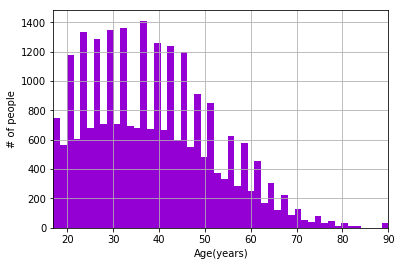

In [112]:
ax=data_train['age'].hist(bins=50, range=(data_train['age'].min(),data_train['age'].max()),color='darkviolet').set_xlim(data_train['age'].min(),data_train['age'].max())
plt.xlabel('Age(years)')
plt.ylabel('# of people')
plt.show()

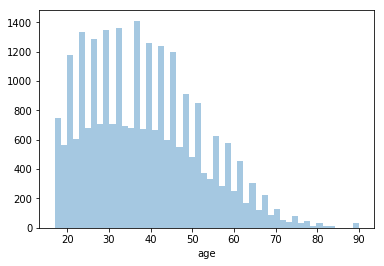

In [576]:
sns.distplot(data_train.age.dropna(),kde=False)
plt.show()

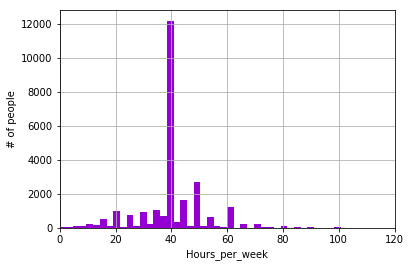

In [74]:
ax=data_train['hours_per_week'].hist(bins=50, range=(0,120),color='darkviolet').set_xlim((0,120))
plt.xlabel('Hours_per_week')
plt.ylabel('# of people')
plt.show()

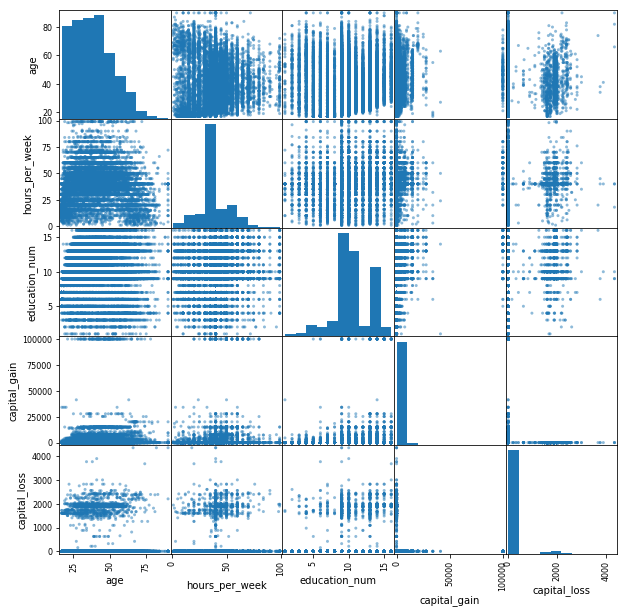

In [501]:
scatter_matrix(data_train[['age', 'hours_per_week','education_num','capital_gain','capital_loss']], alpha=0.5, figsize=(10, 10))
plt.show()

## Some observations based on numerical data:
- One can see tendency for older people to work less number hours per week (young people (~20y.o.) seem to do this as well)
- There may be some outliers with age=99
- People with higher education tend to start working later (which makes sense, since they are in school)
- Clear peak at 40 hrs/week
- Above mentioned outliers of the 99999 in the capital gain

### Let's check if test data set has similar distributions:

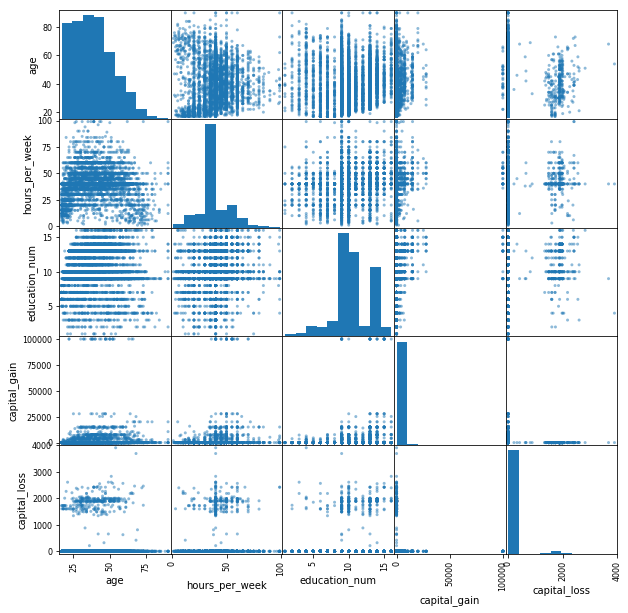

In [502]:
scatter_matrix(data_test[['age', 'hours_per_week','education_num','capital_gain','capital_loss']], alpha=0.5, figsize=(10, 10))
plt.show()

### Let's also see how numerical data differs for people with low and high yearly income
- People with higher education tend to have higher income (not surpringly)
- Capital gain outliers are present in people with high income 

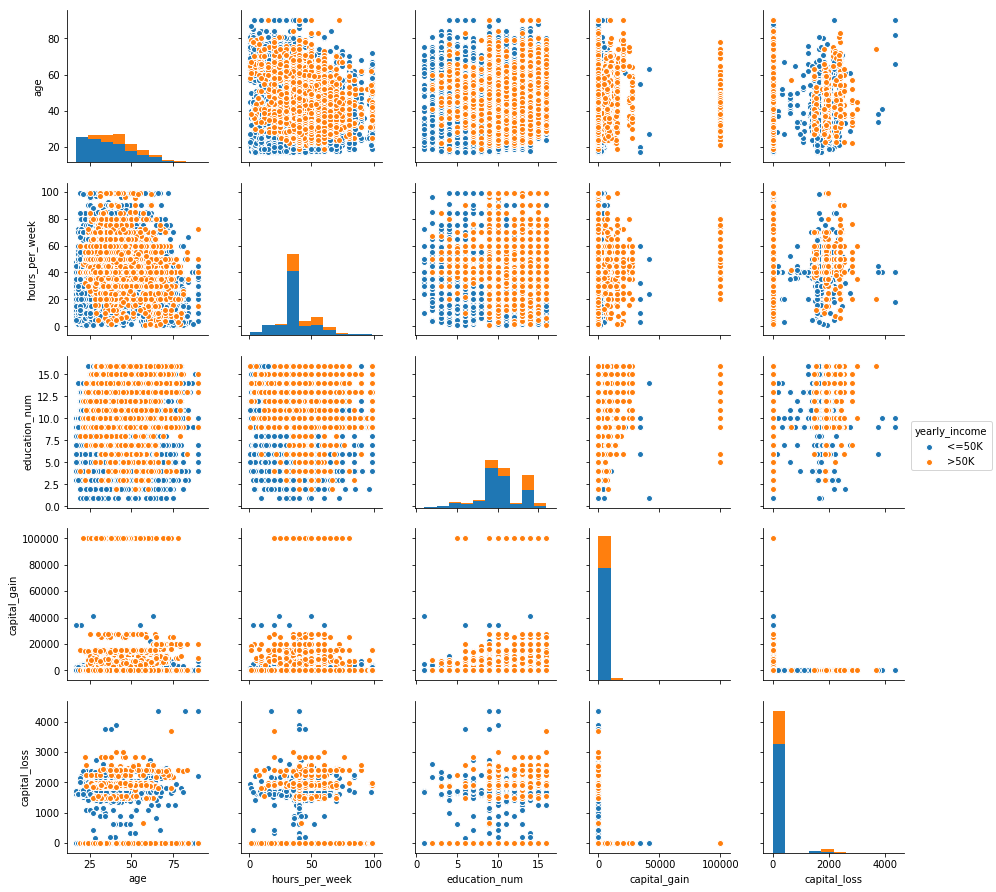

In [149]:
sns.pairplot(data_train[['age', 'hours_per_week','education_num','capital_gain','capital_loss','yearly_income']],hue='yearly_income')
plt.show()

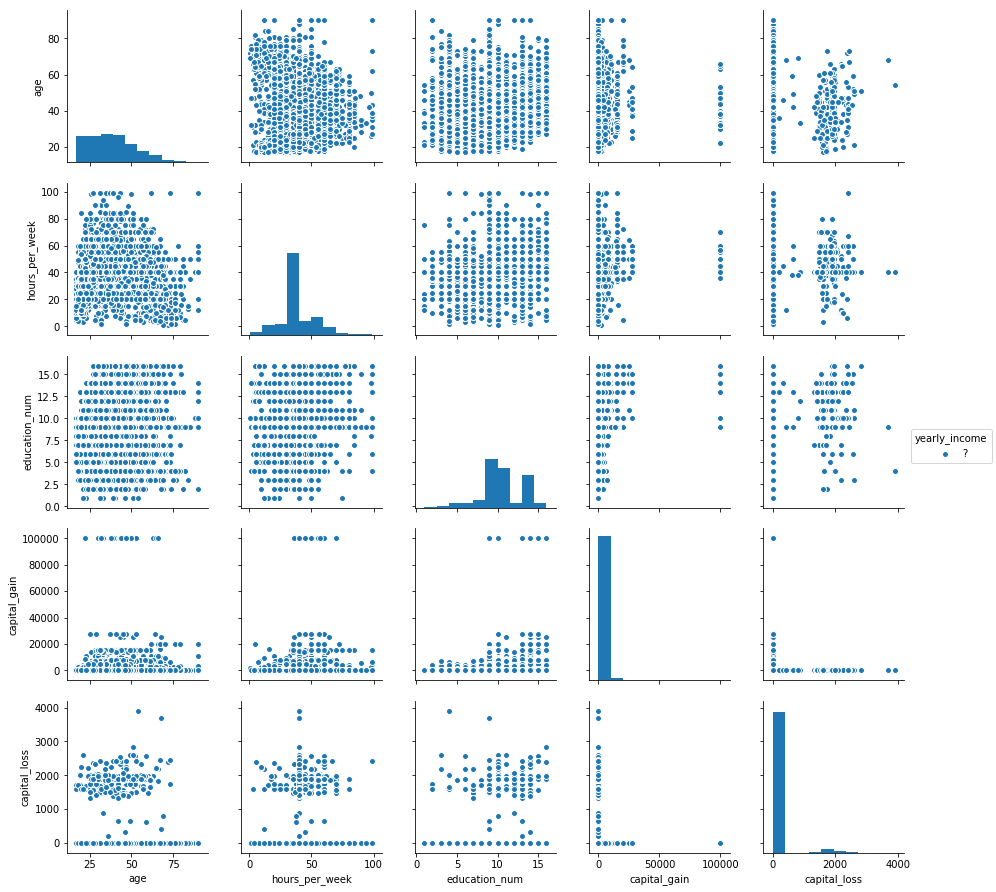

In [150]:
sns.pairplot(data_test[['age', 'hours_per_week','education_num','capital_gain','capital_loss','yearly_income']],hue='yearly_income')
plt.show()

### At least visually train and test data look about the same and therefore we should be able to use the train data for model creation

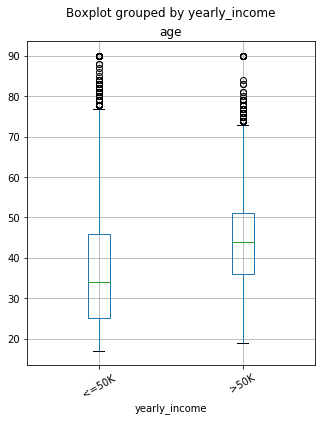

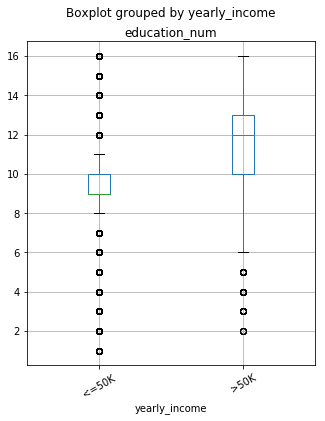

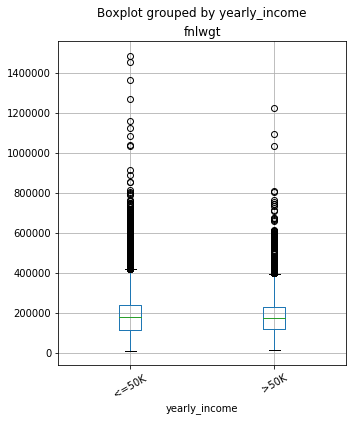

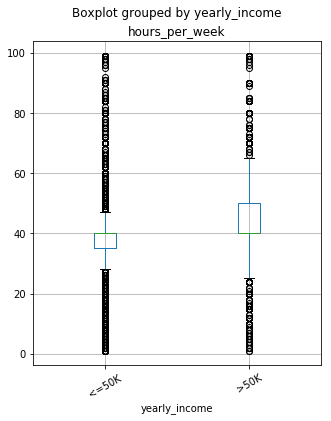

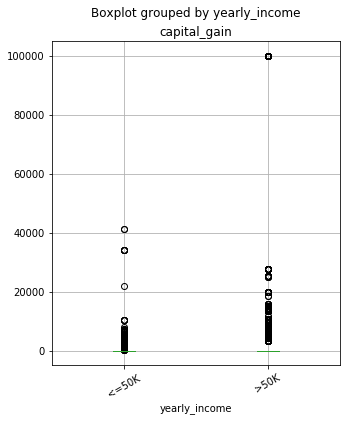

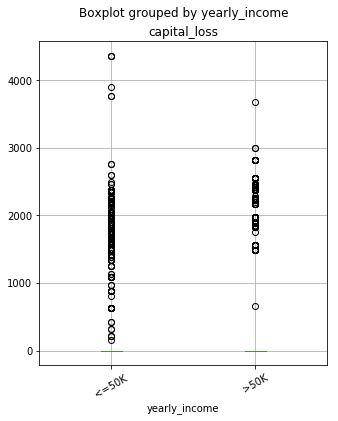

In [579]:
cols=['age','education_num','fnlwgt','hours_per_week','capital_gain','capital_loss']
for i in range(len(cols)):
    data_train.boxplot(cols[i],'yearly_income',rot = 30,figsize=(5,6))
plt.show()

In [48]:
print("Age: Min="+str(data_train['age'].min())+" Max="+str(data_train['age'].max())+" Mean="+str(data_train['age'].mean())  )
print("Hours_per_week: Min="+str(data_train['hours_per_week'].min())+" Max="+str(data_train['hours_per_week'].max())+" Mean="+str(data_train['hours_per_week'].mean())  )

Age: Min=17 Max=90 Mean=38.589274060424586
Hours_per_week: Min=1 Max=99 Mean=40.43905716150332


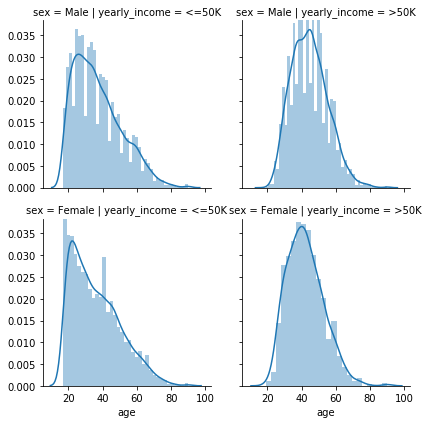

In [138]:
g = sns.FacetGrid(data_train, row='sex',col='yearly_income')
g.map(sns.distplot, "age")
plt.show()

### Both men and women have similar age distributions, which however depend on the yearly_income

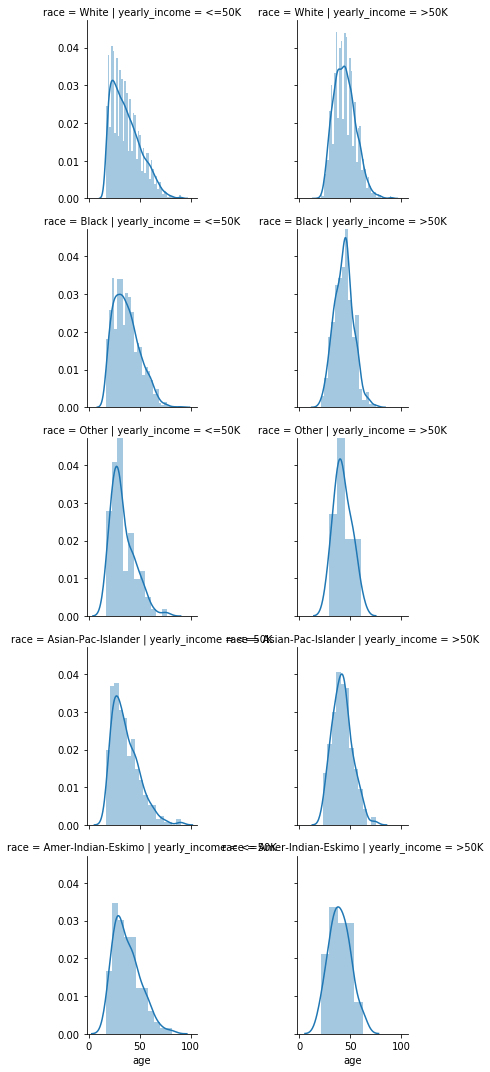

In [139]:
g = sns.FacetGrid(data_train, row='race',col='yearly_income')
g.map(sns.distplot, "age")
plt.show()

In [ ]:
g = sns.FacetGrid(df, col='color', hue='color', col_wrap=4)
g.map(sns.regplot, 'carat', 'price');

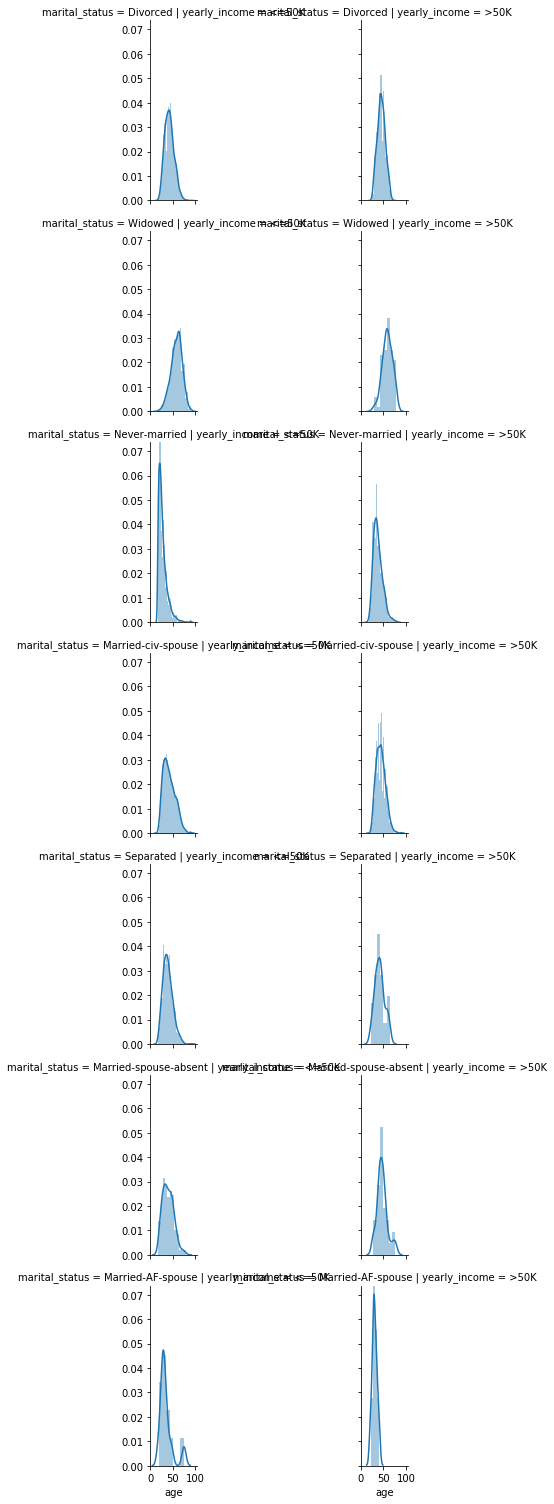

In [140]:
g = sns.FacetGrid(data_train, row='marital_status',col='yearly_income')
g.map(sns.distplot, "age")
plt.show()

### People who have never been married are less to have high income compared to those who are married or was married before

In [582]:
data_train['occupation'].value_counts()

Prof-specialty       3322
Exec-managerial      3259
Craft-repair         3252
Adm-clerical         3017
Sales                2883
Other-service        2677
Machine-op-inspct    1606
?                    1471
Transport-moving     1285
Handlers-cleaners    1085
Farming-fishing       822
Tech-support          724
Protective-serv       519
Priv-house-serv       120
Armed-Forces            7
Name: occupation, dtype: int64

In [583]:
data_train['workclass'].value_counts()

Private             18152
Self-emp-not-inc     2022
Local-gov            1676
?                    1465
State-gov            1040
Self-emp-inc          901
Federal-gov           777
Without-pay            10
Never-worked            6
Name: workclass, dtype: int64

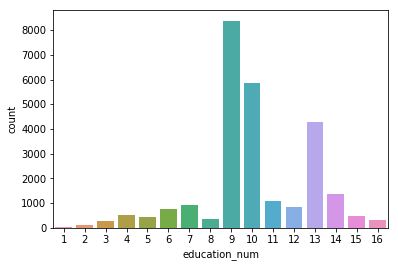

In [584]:
cat_features=["education_num"]
sns.countplot(x=cat_features[0], data=data_train)

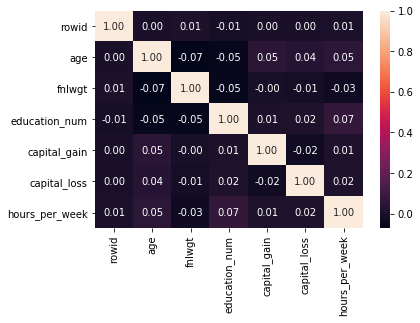

In [153]:
sns.heatmap(data_train[data_train.yearly_income=='<=50K'].corr(), annot=True, fmt=".2f") #, square=True
plt.show()

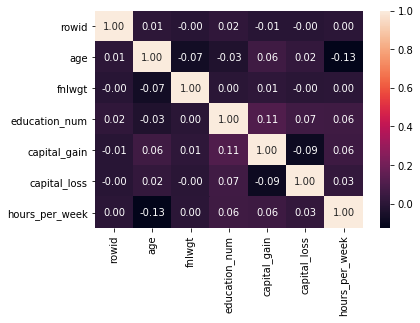

In [119]:
sns.heatmap(data_train[data_train.yearly_income=='>50K'].corr(), annot=True, fmt=".2f")
plt.show()

### Education and capital gain show positive Pearson correlation for people making >50k, but not for people with <50k. (and capital loss has negative corr) For people making >50k, the hours per week have negative correlation with age, why correlation is positive for <=50k.

# Section 2

## 2a. Calculate for different age ranges:
- the mean of hours-per-week
- the median of education level
- Use bins of width 10 (i.e. ages 20-30, 30-40, etc.)

In [155]:
# Use 8 age bins
age_bins = np.linspace(10, 90, 9)
age_labels=['<20','20-30','30-40','40-50','50-60','60-70','70-80','>80']

In [156]:
age_groups=pd.cut(data_train.age, age_bins,labels=age_labels)
data_train['age_group']=age_groups

age_group
<20      28.564854
20-30    39.415547
30-40    43.195963
40-50    43.467328
50-60    42.535995
60-70    35.075577
70-80    26.746356
>80      27.740260
Name: hours_per_week, dtype: float64


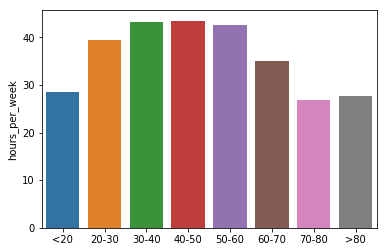

In [192]:
hrs_vs_age=data_train.groupby(['age_group'])['hours_per_week'].mean()
print(hrs_vs_age)
sns.barplot(x=age_labels, y=hrs_vs_age)
plt.show()

### People in the 30-60 age group work the most

age_group
<20       9
20-30    10
30-40    10
40-50    10
50-60     9
60-70     9
70-80     9
>80       9
Name: education_num, dtype: int64


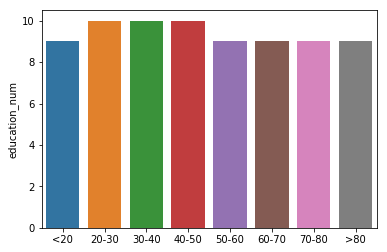

In [193]:
ed_vs_age=data_train.groupby(['age_group'])['education_num'].median()
print(ed_vs_age)
sns.barplot(x=age_labels, y=ed_vs_age)
plt.show()

### People in the 20-50 age group have the highest median level of education

## 2b. Median age for males and females by occupation

In [580]:
print("Median age for males by occupation:")
data_train[data_train.sex=='Male'].groupby(['occupation'])['age'].median()

Median age for males by occupation:


occupation
?                    47.0
Adm-clerical         36.0
Armed-Forces         24.0
Craft-repair         38.0
Exec-managerial      43.0
Farming-fishing      40.0
Handlers-cleaners    29.0
Machine-op-inspct    36.0
Other-service        31.0
Priv-house-serv      23.0
Prof-specialty       40.0
Protective-serv      36.5
Sales                38.0
Tech-support         37.0
Transport-moving     40.0
Name: age, dtype: float64

In [581]:
print("Median age for females by occupation:")
data_train[data_train.sex=='Female'].groupby(['occupation'])['age'].median()

Median age for females by occupation:


occupation
?                    29.0
Adm-clerical         35.0
Craft-repair         39.0
Exec-managerial      39.0
Farming-fishing      39.0
Handlers-cleaners    32.0
Machine-op-inspct    37.0
Other-service        33.0
Priv-house-serv      39.5
Prof-specialty       38.0
Protective-serv      32.0
Sales                29.0
Tech-support         32.0
Transport-moving     38.0
Name: age, dtype: float64

In [ ]:
#One can also output both at the same time, but it was a bit harder for me to read the results
#data_train.groupby(['occupation','sex'])['age'].median()

# Section 3

## Section 3.1 - Initial kNN model development and exploration

###  - For kNN model it is essential to scale the data, since it is using euclidian (or another if prefered) distance to determine distances between neighbours, which are used for classification. 
### - Secondly, scikit-learn in python can not handle categorical variables, so one needs to apply one-hot encoding 

## Let's start building the model by using numerical data only
- rowid column does not seem to carry any info and will be omitted
- I am not clear if fnlwgt has any value either so I will omit is as well for now. One can add it later.
- let's include education_num into numerical features for now. One can later explore if it is better to handle it as categorical

In [214]:
# Define X and Y
X_data_train_num=data_train[['age', 'hours_per_week','education_num','capital_gain','capital_loss']].values
Y_data_train_num=data_train[['yearly_income']].values

#### Split data into 2 parts: 1st we'll use for cross-valiadation, 2nd for estimation of the model trained after cross-validation

In [223]:
X_num_train, X_num_valid, y_num_train, y_num_valid = train_test_split(X_data_train_num, Y_data_train_num, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=Y_data_train_num)

#### Define cross-validation: 3-fold, with shuffle, random state=17 for reproducibility

In [253]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

#### Let's look of what we get without scaling

In [251]:
knn = KNeighborsClassifier(n_neighbors=10,n_jobs=-1)
knn.fit(X_num_train_scaled,y_num_train)
print('Training accuracy: ',round(cross_val_score(knn, X_num_train, y_num_train, scoring = 'accuracy',cv=skf).mean(),3))
print('Validation accuracy: ', round(knn.score(X_num_valid, y_num_valid),3))

Training accuracy:  0.83
Validation accuracy:  0.782


### One can see that there is significant overfitting, since model does not generalize well to the validation data

### kNN works best with scaled data

In [254]:
scaler = StandardScaler()
# I have also tried MinMaxScaler(), but results were slightly worse. May need to try again later
X_num_train_scaled = scaler.fit_transform(X_num_train,y_num_train)
X_num_valid_scaled = scaler.transform(X_num_valid)

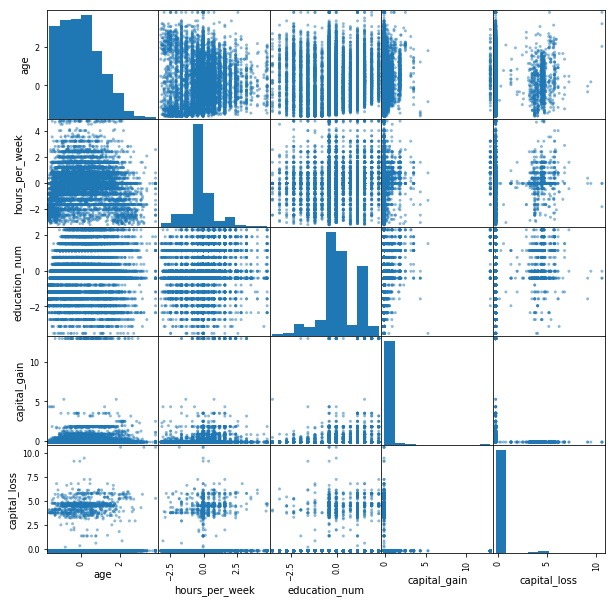

In [264]:
# Visualize scaled numerical data - outliers in the capital gain may be affecting the scaling
numeric_cols=['age', 'hours_per_week','education_num','capital_gain','capital_loss']
data_numeric_scaled  = pd.DataFrame(X_num_train_scaled, columns=numeric_cols)
scatter_matrix(data_numeric_scaled, alpha=0.5, figsize=(10, 10))
plt.show()

In [258]:
knn = KNeighborsClassifier(n_neighbors=20,n_jobs=-1) # numbers in the range 10-30 seem to give the best results
knn.fit(X_num_train_scaled,y_num_train)
print('Training accuracy: ',round(cross_val_score(knn, X_num_train_scaled, y_num_train, scoring = 'accuracy',cv=skf).mean(),3))
print('Validation accuracy: ', round(knn.score(X_num_valid_scaled, y_num_valid),3))

Training accuracy:  0.82
Validation accuracy:  0.821


### Validation accuracy has significantly improved

### Now, let's add categorical variables, which need to be one hot encoded (and also scaled)

In [259]:
data_train.head()

,rowid,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,yearly_income,age_group
0,1,38,Private,108907,HS-grad,9,Divorced,Craft-repair,Not-in-family,White,Male,0,0,40,?,<=50K,30-40
1,3,58,Self-emp-not-inc,33309,HS-grad,9,Widowed,Farming-fishing,Not-in-family,White,Male,0,0,80,United-States,<=50K,50-60
2,4,62,Private,169204,HS-grad,9,Widowed,Craft-repair,Unmarried,White,Male,0,0,40,United-States,<=50K,60-70
3,5,53,Private,82646,Doctorate,16,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,55,United-States,>50K,50-60
4,6,40,Local-gov,233891,HS-grad,9,Never-married,Adm-clerical,Unmarried,Black,Female,0,0,35,United-States,<=50K,30-40


In [267]:
X_data_train_cat=data_train[['workclass', 'marital_status','occupation','relationship','race','sex','native_country']]
#don't need to include education since it is already encoded and included in numerical features

In [270]:
#one of the ways to transform categorical data (different approach in the next section)
encoder = DV(sparse = False)
X_cat_oh = encoder.fit_transform(X_data_train_cat.T.to_dict().values())

In [271]:
X_train_cat_oh, X_valid_cat_oh = train_test_split(X_cat_oh, 
                                   test_size=0.3, 
                                   random_state=17, stratify=Y_data_train_num)

In [277]:
X_train_comb=np.hstack( (X_num_train_scaled, X_train_cat_oh) )
X_valid_comb=np.hstack( (X_num_valid_scaled, X_valid_cat_oh) )

In [274]:
X_valid_comb.shape

(7815, 91)

In [280]:
X_train_comb.shape

(18234, 91)

In [282]:
y_num_valid.shape

(7815, 1)

In [286]:
knn = KNeighborsClassifier(n_neighbors=20,n_jobs=-1) # numbers in the range 10-30 seem to give the best results
knn.fit(X_train_comb,y_num_train)
print('Training accuracy: ',round(cross_val_score(knn, X_train_comb, y_num_train, scoring = 'accuracy',cv=skf).mean(),3))
print('Validation accuracy: ', round(knn.score(X_valid_comb, y_num_valid),3))

Training accuracy:  0.842
Validation accuracy:  0.846


## Adding the categorical features have significantly improved the model accuracy 

# Section 3.2 - Let's clean up the model a bit:
- one hot encoding needs to include categorical test data as well
- remove outliers in the capital_gain
- transform test data

In [588]:
data_train = pd.read_csv('IncomePredictionTrain.txt')
data_test = pd.read_csv('IncomePredictionTest.txt')

In [589]:
data_train.describe()

,rowid,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,26049.000000,26049.000000,2.604900e+04,26049.000000,26049.000000,26049.000000,26049.000000
mean,16271.319590,38.589274,1.894995e+05,10.078199,1077.775423,85.858190,40.439057
std,9402.676798,13.614376,1.054885e+05,2.577200,7403.682592,400.481239,12.411520
min,1.000000,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,8141.000000,28.000000,1.177670e+05,9.000000,0.000000,0.000000,40.000000
50%,16256.000000,37.000000,1.780250e+05,10.000000,0.000000,0.000000,40.000000
75%,24432.000000,48.000000,2.368050e+05,12.000000,0.000000,0.000000,45.000000
max,32561.000000,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [590]:
data_train[data_train.capital_gain>50000].describe()

,rowid,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,128.000000,128.000000,128.000000,128.000000,128.0,128.0,128.000000
mean,15946.867188,47.007812,197811.078125,12.968750,99999.0,0.0,49.835938
std,9476.064814,10.845730,104640.009078,2.481229,0.0,0.0,13.196144
min,602.000000,21.000000,25468.000000,5.000000,99999.0,0.0,20.000000
25%,7314.250000,40.000000,128519.250000,11.750000,99999.0,0.0,40.000000
50%,17750.000000,47.000000,176542.000000,13.000000,99999.0,0.0,50.000000
75%,23841.250000,53.250000,239359.750000,15.000000,99999.0,0.0,60.000000
max,31744.000000,78.000000,553405.000000,16.000000,99999.0,0.0,80.000000


### Eliminating large capital_gain outliers further improves accuracy
- One can explore a different approach later - perhaps a new column indicating whether a record had outliers or not can be added

In [611]:
data_train['capital_gain'] = data_train['capital_gain'].apply(lambda x: x if x <= 50000. else -10000.)

In [612]:
data_train.describe()

,rowid,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,26049.000000,26049.000000,2.604900e+04,26049.000000,26049.000000,26049.000000,26049.000000
mean,16271.319590,38.589274,1.894995e+05,10.078199,537.260547,85.858190,40.439057
std,9402.676798,13.614376,1.054885e+05,2.577200,2653.268654,400.481239,12.411520
min,1.000000,17.000000,1.228500e+04,1.000000,-10000.000000,0.000000,1.000000
25%,8141.000000,28.000000,1.177670e+05,9.000000,0.000000,0.000000,40.000000
50%,16256.000000,37.000000,1.780250e+05,10.000000,0.000000,0.000000,40.000000
75%,24432.000000,48.000000,2.368050e+05,12.000000,0.000000,0.000000,45.000000
max,32561.000000,90.000000,1.484705e+06,16.000000,41310.000000,4356.000000,99.000000


In [613]:
X_data_train_num=data_train[['age','education_num','capital_gain','capital_loss','hours_per_week']].values
Y_data_train_num=data_train[['yearly_income']].values
X_data_test_num=data_test[['age','education_num','capital_gain','capital_loss','hours_per_week']].values

In [614]:
data_train[['age','education_num', 'capital_gain','capital_loss','hours_per_week']].head()

,age,education_num,capital_gain,capital_loss,hours_per_week
0,38,9,0.0,0,40
1,58,9,0.0,0,80
2,62,9,0.0,0,40
3,53,16,0.0,0,55
4,40,9,0.0,0,35


In [615]:
X_data_train_cat=data_train[['workclass', 'marital_status','occupation','relationship','race','sex','native_country']]
X_data_test_cat=data_test[['workclass', 'marital_status','occupation','relationship','race','sex','native_country']]

In [616]:
X_cat = pd.concat([X_data_train_cat, X_data_test_cat], ignore_index=True)

In [617]:
print(X_data_train_cat.shape[0])
print(X_data_test_cat.shape[0])
print(X_cat.shape[0])

26049
6512
32561


In [618]:
X_cat.head()

,workclass,marital_status,occupation,relationship,race,sex,native_country
0,Private,Divorced,Craft-repair,Not-in-family,White,Male,?
1,Self-emp-not-inc,Widowed,Farming-fishing,Not-in-family,White,Male,United-States
2,Private,Widowed,Craft-repair,Unmarried,White,Male,United-States
3,Private,Divorced,Exec-managerial,Not-in-family,White,Female,United-States
4,Local-gov,Never-married,Adm-clerical,Unmarried,Black,Female,United-States


### Encode categorical features

In [619]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
# encoding using positive integers and combining categories
for col in X_cat.columns:  
    X_cat[col] = enc.fit_transform(X_cat[col])
# dummy-encoding
dummies = pd.get_dummies(X_cat.astype(str), drop_first=True)
dummies_train = dummies.iloc[:X_data_train_cat.shape[0], :]
dummies_test = dummies.iloc[X_data_train_cat.shape[0]:, :]

### Split train numerical and categorical data into train and validation test set

In [620]:
X_num_train, X_num_valid, y_num_train, y_num_valid = train_test_split(X_data_train_num, Y_data_train_num, 
                                                     test_size=0.3, 
                                                     random_state=17, stratify=Y_data_train_num)

X_train_cat_oh, X_valid_cat_oh = train_test_split(dummies_train, 
                                   test_size=0.3, 
                                   random_state=17, stratify=Y_data_train_num)

In [621]:
scaler = StandardScaler()
X_num_train_scaled = scaler.fit_transform(X_num_train) #,y_num_train
X_num_valid_scaled = scaler.transform(X_num_valid)
X_num_test_scaled = scaler.transform(X_data_test_num)

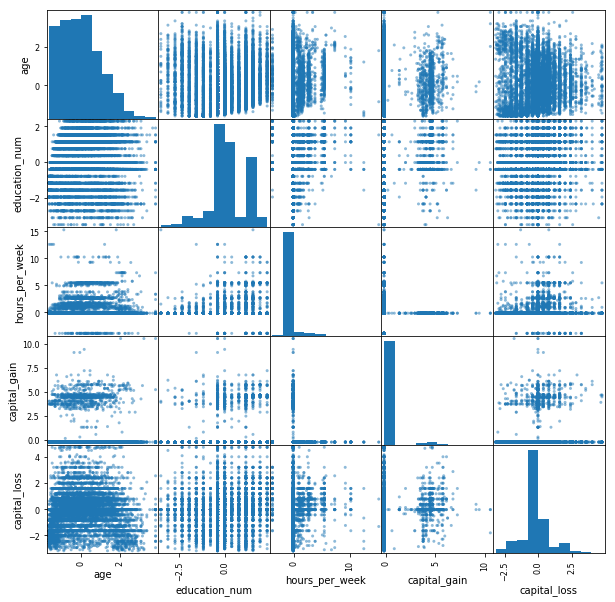

In [622]:
numeric_cols=['age','education_num', 'hours_per_week','capital_gain','capital_loss']
data_numeric_scaled  = pd.DataFrame(X_num_train_scaled, columns=numeric_cols)
scatter_matrix(data_numeric_scaled, alpha=0.5, figsize=(10, 10))
plt.show()

In [623]:
# Combine numerical and categorical features 
# training and validation data
X_train_comb=np.hstack( (X_num_train_scaled, X_train_cat_oh) )
X_valid_comb=np.hstack( (X_num_valid_scaled, X_valid_cat_oh) )

# test data
X_test_comb = np.hstack((X_num_test_scaled, dummies_test))

In [624]:
dummies_test.shape

(6512, 79)

In [625]:
X_num_test_scaled.shape

(6512, 5)

In [626]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

In [627]:
knn = KNeighborsClassifier(n_neighbors=20,n_jobs=-1) # numbers in the range 10-30 seem to give the best results
knn.fit(X_train_comb,y_num_train)
print('Training accuracy: ',round(cross_val_score(knn, X_train_comb, y_num_train, scoring = 'accuracy',cv=skf).mean(),3))
print('Validation accuracy: ', round(knn.score(X_valid_comb, y_num_valid),3))

Training accuracy:  0.849
Validation accuracy:  0.855


## The accuracy further improved!

## Let's now make predictions on the test data, which has already been preprocessed above:

In [629]:
y_test_predict=knn.predict(X_test_comb)

In [630]:
y_test_predict

array(['>50K', '>50K', '<=50K', ..., '<=50K', '<=50K', '<=50K'],
      dtype=object)

In [641]:
with open('Test_predictions.txt', 'w') as f:
    for item in y_test_predict:
        f.write("%s\n" % item)

In [636]:
df_out = pd.DataFrame(X_test_comb)

In [639]:
df_out['y']=y_test_predict

In [640]:
df_out.head()

,0,1,2,3,4,5,6,7,8,9,...,75,76,77,78,79,80,81,82,83,y
0,0.983701,1.899376,-0.197938,6.117854,1.585511,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,>50K
1,0.763081,1.512672,-0.197938,-0.215029,-0.035066,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,>50K
2,-0.487095,1.125968,-0.197938,-0.215029,0.370078,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<=50K
3,0.910161,-0.420849,-0.197938,-0.215029,-0.035066,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<=50K
4,-0.707715,0.352560,-0.197938,-0.215029,-0.035066,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<=50K


In [642]:
df_out.to_csv('predictions.csv')

### One can attempt to improve the model futher based on some of the ideas listed throughout the notebook...